   Sex_male  age  education  currentSmoker  cigsPerDay  BPMeds  \
0         1   39        4.0              0         0.0     0.0   
1         0   46        2.0              0         0.0     0.0   
2         1   48        1.0              1        20.0     0.0   
3         0   61        3.0              1        30.0     0.0   
4         0   46        3.0              1        23.0     0.0   

   prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                0             0         0    195.0  106.0   70.0  26.97   
1                0             0         0    250.0  121.0   81.0  28.73   
2                0             0         0    245.0  127.5   80.0  25.34   
3                0             1         0    225.0  150.0   95.0  28.58   
4                0             0         0    285.0  130.0   84.0  23.10   

   heartRate  glucose  TenYearCHD                   DiseaseType  
0       80.0     77.0           0                      Low Risk  
1       95.0  

C:\Users\arman\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


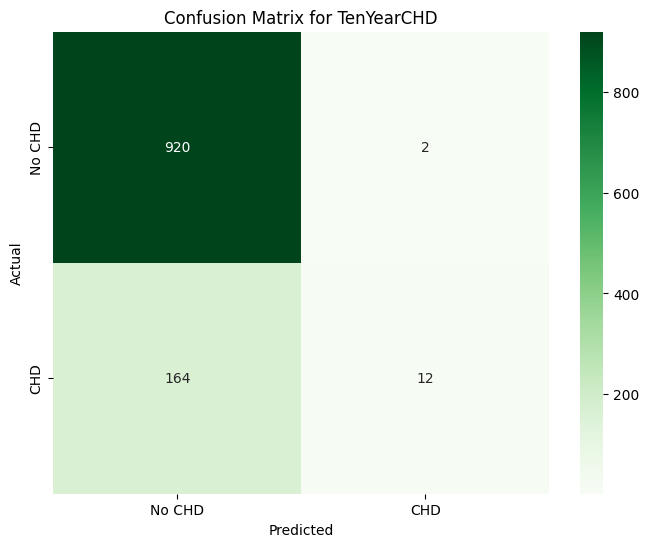

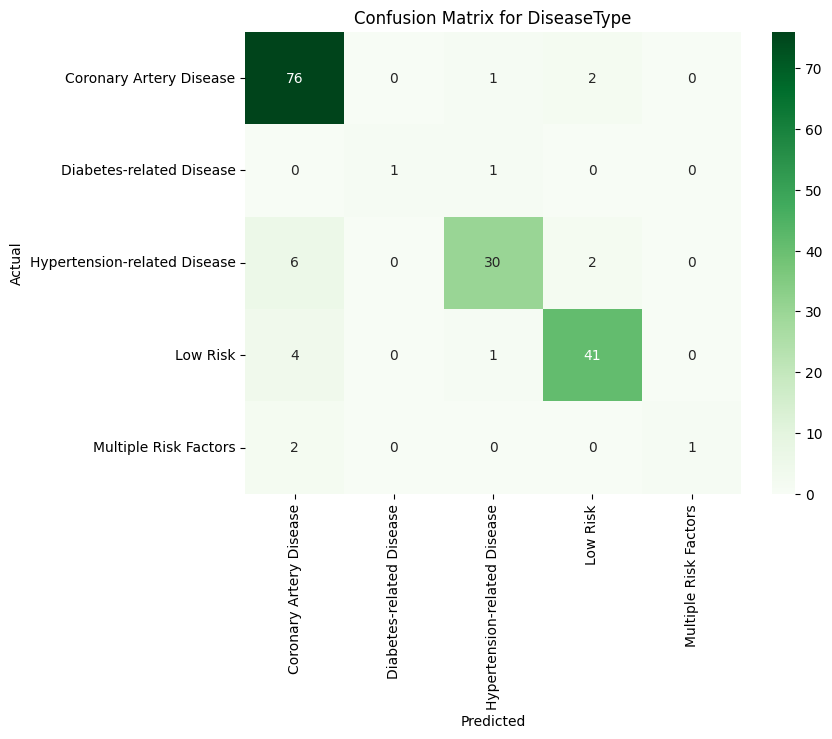


Make Predictions:


Age:  23
Sex (1 for Male, 0 for Female):  1
Cigarettes per day:  23
Total Cholesterol level:  123
Systolic Blood Pressure:  123
Glucose level:  90


The Person does NOT have a Heart Disease (CHD)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

disease_df = pd.read_csv("framingham_modified.csv")  # Combine TenYearCHD and DiseaseType dataset
disease_df.dropna(axis=0, inplace=True)
disease_df.rename(columns={'male': 'Sex_male'}, inplace=True)


print(disease_df.head(), disease_df.shape)
print("Distribution of TenYearCHD:")
print(disease_df['TenYearCHD'].value_counts())
print("Distribution of DiseaseType:")
print(disease_df['DiseaseType'].value_counts())


X = np.asarray(disease_df[['age', 'Sex_male', 'cigsPerDay', 'totChol', 'sysBP', 'glucose']])

y_chd = np.asarray(disease_df['TenYearCHD'])
y_disease_type = np.asarray(disease_df['DiseaseType'])

label_encoder = LabelEncoder()
y_disease_type_encoded = label_encoder.fit_transform(y_disease_type)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train_chd, X_test_chd, y_train_chd, y_test_chd = train_test_split(X_scaled, y_chd, test_size=0.3, random_state=42)

logreg_chd = LogisticRegression(random_state=42)
logreg_chd.fit(X_train_chd, y_train_chd)

y_pred_chd = logreg_chd.predict(X_test_chd)
print("TenYearCHD Model Accuracy:")
print(classification_report(y_test_chd, y_pred_chd))

disease_df_filtered = disease_df[disease_df['TenYearCHD'] == 1]
X_disease = np.asarray(disease_df_filtered[['age', 'Sex_male', 'cigsPerDay', 'totChol', 'sysBP', 'glucose']])
y_disease = np.asarray(disease_df_filtered['DiseaseType'])
y_disease_encoded = label_encoder.transform(y_disease)

X_disease_scaled = scaler.transform(X_disease)

X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(X_disease_scaled, y_disease_encoded, test_size=0.3, random_state=42)

logreg_disease = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
logreg_disease.fit(X_train_dis, y_train_dis)

y_pred_dis = logreg_disease.predict(X_test_dis)
print("DiseaseType Model Accuracy:")
print(classification_report(y_test_dis, y_pred_dis, target_names=label_encoder.classes_))

import joblib
joblib.dump(logreg_chd, 'logreg_chd_model.pkl')
joblib.dump(logreg_disease, 'logreg_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Greens")
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

plot_confusion_matrix(y_test_chd, y_pred_chd, labels=['No CHD', 'CHD'], title="Confusion Matrix for TenYearCHD")
plot_confusion_matrix(y_test_dis, y_pred_dis, labels=label_encoder.classes_, title="Confusion Matrix for DiseaseType")

print("\nMake Predictions:")
age = int(input("Age: "))
sex_male = int(input("Sex (1 for Male, 0 for Female): "))
cigs_per_day = float(input("Cigarettes per day: "))
tot_chol = float(input("Total Cholesterol level: "))
sys_bp = float(input("Systolic Blood Pressure: "))
glucose = float(input("Glucose level: "))

input_data = np.asarray([age, sex_male, cigs_per_day, tot_chol, sys_bp, glucose]).reshape(1, -1)
input_data_scaled = scaler.transform(input_data)

chd_prediction = logreg_chd.predict(input_data_scaled)[0]

if chd_prediction == 0:
    print('The Person does NOT have a Heart Disease (CHD)')
else:
    
    disease_prediction = logreg_disease.predict(input_data_scaled)[0]
    disease_type = label_encoder.inverse_transform([disease_prediction])[0]
    print(f'The Person has Heart Disease: {disease_type}')
